# PyTorch Basics for Federated Learning

This notebook provides a hands-on introduction to PyTorch fundamentals that you'll need for federated learning.

## What You'll Learn

1. **Tensors**: PyTorch's core data structure
2. **Neural Networks**: Building models with `nn.Module`
3. **Training Loop**: Forward pass, loss calculation, backpropagation
4. **Datasets and DataLoaders**: Handling data efficiently
5. **Model Evaluation**: Testing your model
6. **Saving/Loading Models**: Model persistence

By the end, you'll understand the PyTorch concepts used in our federated learning implementation!

## Setup

First, let's import PyTorch and check the version:

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.5.1+cu121
CUDA available: True
Device: cuda


## 1. Tensors: PyTorch's Core Data Structure

Tensors are multi-dimensional arrays, similar to NumPy arrays but with GPU support.

In [15]:
# Creating tensors
print("=" * 50)
print("Creating Tensors")
print("=" * 50)

# From Python list
tensor_from_list = torch.tensor([1, 2, 3, 4, 5])
print(f"\nFrom list: {tensor_from_list}")
print(f"Shape: {tensor_from_list.shape}")
print(f"Data type: {tensor_from_list.dtype}")

# Random tensor (common for initializing weights)
random_tensor = torch.randn(3, 4)  # 3 rows, 4 columns
print(f"\nRandom tensor:\n{random_tensor}")
print(f"Shape: {random_tensor.shape}")

# Zeros and ones
zeros = torch.zeros(2, 3)
ones = torch.ones(2, 3)
print(f"\nZeros tensor:\n{zeros}")
print(f"\nOnes tensor:\n{ones}")

Creating Tensors

From list: tensor([1, 2, 3, 4, 5])
Shape: torch.Size([5])
Data type: torch.int64

Random tensor:
tensor([[ 1.2602, -0.6790, -0.7508,  0.1868],
        [ 1.0086, -1.9902, -0.1975,  0.3999],
        [ 0.2207,  0.8322, -0.4732, -1.3364]])
Shape: torch.Size([3, 4])

Zeros tensor:
tensor([[0., 0., 0.],
        [0., 0., 0.]])

Ones tensor:
tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [16]:
# Tensor operations
print("=" * 50)
print("Tensor Operations")
print("=" * 50)

a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([4.0, 5.0, 6.0])

# Element-wise operations
print(f"\na + b = {a + b}")
print(f"a * b = {a * b}")
print(f"a ** 2 = {a ** 2}")

# Matrix operations
x = torch.randn(2, 3)
y = torch.randn(3, 2)
z = torch.matmul(x, y)  # or x @ y
print(f"\nMatrix multiplication:")
print(f"x shape: {x.shape}, y shape: {y.shape}")
print(f"z = x @ y, shape: {z.shape}")
print(z)

Tensor Operations

a + b = tensor([5., 7., 9.])
a * b = tensor([ 4., 10., 18.])
a ** 2 = tensor([1., 4., 9.])

Matrix multiplication:
x shape: torch.Size([2, 3]), y shape: torch.Size([3, 2])
z = x @ y, shape: torch.Size([2, 2])
tensor([[-0.4678, -1.0107],
        [ 0.0753, -0.1726]])


## 2. Building Neural Networks

In PyTorch, neural networks are built by subclassing `nn.Module`.

In [17]:
# Simple neural network for binary classification
class SimpleClassifier(nn.Module):
    """A simple 3-layer neural network for binary classification."""
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First fully connected layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)  # Second layer
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)  # Output layer
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        """Forward pass through the network."""
        # Layer 1: Linear -> ReLU -> Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # Layer 2: Linear -> ReLU -> Dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output layer (no activation, will use with loss function)
        x = self.fc3(x)
        return x

# Create a model instance
model = SimpleClassifier(input_dim=10, hidden_dim=64, output_dim=2)
print("Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Architecture:
SimpleClassifier(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 2,850
Trainable parameters: 2,850


In [18]:
# Test the model with dummy data
print("Testing the model with dummy data:")
dummy_input = torch.randn(5, 10)  # Batch of 5 samples, 10 features each
print(f"Input shape: {dummy_input.shape}")

# Forward pass
output = model(dummy_input)
print(f"Output shape: {output.shape}")
print(f"Output (logits):\n{output}")

# Convert to probabilities
probabilities = F.softmax(output, dim=1)
print(f"\nProbabilities:\n{probabilities}")

# Get predictions (class with highest probability)
predictions = torch.argmax(probabilities, dim=1)
print(f"\nPredicted classes: {predictions}")

Testing the model with dummy data:
Input shape: torch.Size([5, 10])
Output shape: torch.Size([5, 2])
Output (logits):
tensor([[ 0.0240,  0.0342],
        [ 0.0213,  0.0603],
        [ 0.3241,  0.0591],
        [ 0.3052,  0.1298],
        [-0.0167, -0.0716]], grad_fn=<AddmmBackward0>)

Probabilities:
tensor([[0.4974, 0.5026],
        [0.4902, 0.5098],
        [0.5659, 0.4341],
        [0.5437, 0.4563],
        [0.5137, 0.4863]], grad_fn=<SoftmaxBackward0>)

Predicted classes: tensor([1, 1, 0, 0, 0])


## 3. Datasets and DataLoaders

PyTorch provides `Dataset` and `DataLoader` classes for efficient data handling.

In [19]:
# Create a simple dataset
class SimpleDataset(Dataset):
    """A simple dataset for demonstration."""
    
    def __init__(self, n_samples=1000, n_features=10):
        # Generate synthetic data
        self.X = torch.randn(n_samples, n_features)
        # Binary labels (0 or 1)
        self.y = torch.randint(0, 2, (n_samples,))
    
    def __len__(self):
        """Return the size of the dataset."""
        return len(self.y)
    
    def __getitem__(self, idx):
        """Get a single sample."""
        return self.X[idx], self.y[idx]

# Create dataset and dataloader
dataset = SimpleDataset(n_samples=1000, n_features=10)
print(f"Dataset size: {len(dataset)}")

# DataLoader for batching
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Number of batches: {len(dataloader)}")

# Iterate through batches
print("\nFirst batch:")
for batch_X, batch_y in dataloader:
    print(f"Batch X shape: {batch_X.shape}")
    print(f"Batch y shape: {batch_y.shape}")
    print(f"Labels in batch: {batch_y[:10]}")
    break  # Just show the first batch

Dataset size: 1000
Number of batches: 32

First batch:
Batch X shape: torch.Size([32, 10])
Batch y shape: torch.Size([32])
Labels in batch: tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 1])


## 4. Training a Neural Network

The training loop consists of:
1. **Forward pass**: Pass data through the model
2. **Calculate loss**: Compare predictions with actual labels
3. **Backward pass**: Calculate gradients
4. **Update weights**: Adjust parameters using optimizer

In [20]:
# Prepare for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}")

# Create model, loss function, and optimizer
model = SimpleClassifier(input_dim=10, hidden_dim=64, output_dim=2).to(device)
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create train and test datasets
train_dataset = SimpleDataset(n_samples=800, n_features=10)
test_dataset = SimpleDataset(n_samples=200, n_features=10)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training on: cuda
Training samples: 800
Test samples: 200


In [21]:
# Training function
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train the model for one epoch."""
    model.train()  # Set to training mode
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Move data to device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    """Evaluate the model on test data."""
    model.eval()  # Set to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradient computation during evaluation
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total
    return avg_loss, accuracy

print("Training functions defined!")

Training functions defined!


In [22]:
# Train the model
num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...\n")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print()

print("Training completed!")

Starting training...

Epoch [1/10]
  Train Loss: 0.6972, Train Acc: 0.4988
  Test Loss: 0.6941, Test Acc: 0.4500

Epoch [2/10]
  Train Loss: 0.6939, Train Acc: 0.4963
  Test Loss: 0.6952, Test Acc: 0.5050

Epoch [3/10]
  Train Loss: 0.6916, Train Acc: 0.5012
  Test Loss: 0.6960, Test Acc: 0.5100

Epoch [4/10]
  Train Loss: 0.6857, Train Acc: 0.5537
  Test Loss: 0.6963, Test Acc: 0.5250

Epoch [5/10]
  Train Loss: 0.6877, Train Acc: 0.5400
  Test Loss: 0.6974, Test Acc: 0.5250

Epoch [6/10]
  Train Loss: 0.6826, Train Acc: 0.5637
  Test Loss: 0.6977, Test Acc: 0.5100

Epoch [7/10]
  Train Loss: 0.6843, Train Acc: 0.5475
  Test Loss: 0.7004, Test Acc: 0.5200

Epoch [8/10]
  Train Loss: 0.6834, Train Acc: 0.5525
  Test Loss: 0.7001, Test Acc: 0.5050

Epoch [9/10]
  Train Loss: 0.6786, Train Acc: 0.5725
  Test Loss: 0.6992, Test Acc: 0.5200

Epoch [10/10]
  Train Loss: 0.6851, Train Acc: 0.5425
  Test Loss: 0.6987, Test Acc: 0.5150

Training completed!


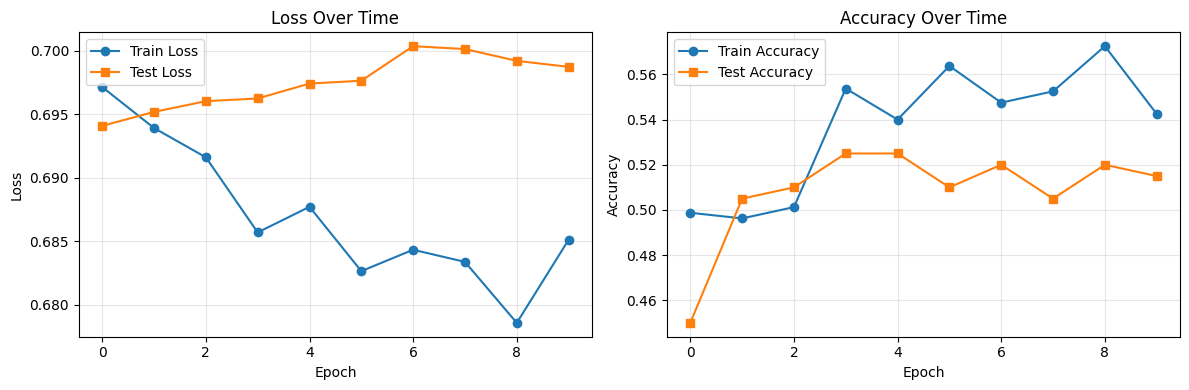

Final Test Accuracy: 0.5150


In [23]:
# Visualize training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(test_losses, label='Test Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
ax2.plot(test_accuracies, label='Test Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

## 5. Saving and Loading Models

PyTorch provides two ways to save models:
1. **Save state_dict** (recommended): Save only the parameters
2. **Save entire model**: Save the model architecture and parameters

In [24]:
import os

# Create directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Method 1: Save state_dict (recommended)
model_path = 'models/simple_classifier.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Load the model
loaded_model = SimpleClassifier(input_dim=10, hidden_dim=64, output_dim=2).to(device)
loaded_model.load_state_dict(torch.load(model_path, weights_only=True))
loaded_model.eval()
print("Model loaded successfully!")

# Verify the loaded model works
test_loss, test_acc = evaluate(loaded_model, test_loader, criterion, device)
print(f"Loaded model test accuracy: {test_acc:.4f}")

Model saved to models/simple_classifier.pth
Model loaded successfully!
Loaded model test accuracy: 0.5150


## 6. Making Predictions

Let's use our trained model to make predictions on new data.

In [25]:
# Create some new data for prediction
new_data = torch.randn(5, 10).to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(new_data)
    probabilities = F.softmax(outputs, dim=1)
    predictions = torch.argmax(probabilities, dim=1)

print("Predictions for new data:")
print("=" * 50)
for i in range(len(new_data)):
    print(f"Sample {i+1}:")
    print(f"  Predicted class: {predictions[i].item()}")
    print(f"  Confidence: {probabilities[i][predictions[i]].item():.4f}")
    print(f"  Class 0 prob: {probabilities[i][0].item():.4f}")
    print(f"  Class 1 prob: {probabilities[i][1].item():.4f}")
    print()

Predictions for new data:
Sample 1:
  Predicted class: 0
  Confidence: 0.5136
  Class 0 prob: 0.5136
  Class 1 prob: 0.4864

Sample 2:
  Predicted class: 1
  Confidence: 0.5667
  Class 0 prob: 0.4333
  Class 1 prob: 0.5667

Sample 3:
  Predicted class: 1
  Confidence: 0.5708
  Class 0 prob: 0.4292
  Class 1 prob: 0.5708

Sample 4:
  Predicted class: 0
  Confidence: 0.5574
  Class 0 prob: 0.5574
  Class 1 prob: 0.4426

Sample 5:
  Predicted class: 1
  Confidence: 0.5228
  Class 0 prob: 0.4772
  Class 1 prob: 0.5228



## 7. Connection to Federated Learning

Now that you understand PyTorch basics, here's how they connect to federated learning:

### Key Connections:

1. **Model Architecture**: Same `nn.Module` structure
   - In FL: Each client has the same model architecture
   - Models are initialized with the same structure

2. **Training Loop**: Similar process
   - In FL: Each client runs its own training loop locally
   - Training happens on local data

3. **Model Parameters**: The key to FL
   - `model.parameters()` or `model.state_dict()` are what get shared
   - Clients send parameters (not data!) to the server

4. **DataLoaders**: Handle local data
   - Each client has its own DataLoader
   - Data stays local, never sent to server

### What's Different in Federated Learning?

- **Multiple training locations**: Different clients train on different data
- **Parameter aggregation**: Server averages parameters from multiple clients
- **Communication rounds**: Training happens over multiple rounds
- **Data privacy**: Raw data never leaves the client

In [26]:
# Example: Extracting and setting parameters (used in FL)
print("Model Parameters for Federated Learning:")
print("=" * 50)

# Get parameters as list of numpy arrays (how Flower does it)
def get_parameters(model):
    return [param.cpu().detach().numpy() for param in model.parameters()]

# Set parameters from list of numpy arrays
def set_parameters(model, parameters):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = {k: torch.tensor(v) for k, v in params_dict}
    model.load_state_dict(state_dict, strict=True)

# Extract parameters
params = get_parameters(model)
print(f"Number of parameter arrays: {len(params)}")
print(f"Shape of first parameter array: {params[0].shape}")
print(f"\nTotal parameters: {sum(p.size for p in params):,}")

# This is what gets sent in federated learning!
print("\n In FL, only these parameters are sent to the server")
print(" The raw data stays on the client")
print(" This preserves privacy!")

Model Parameters for Federated Learning:
Number of parameter arrays: 6
Shape of first parameter array: (64, 10)

Total parameters: 2,850

 In FL, only these parameters are sent to the server
 The raw data stays on the client
 This preserves privacy!


## Summary

Congratulations! You've learned the PyTorch fundamentals needed for federated learning:

 **Tensors**: PyTorch's data structure for neural networks

 **Neural Networks**: Building models with `nn.Module`

 **Training**: Forward pass, loss calculation, backpropagation, optimization

 **Data Handling**: Datasets and DataLoaders

 **Evaluation**: Testing model performance

 **Model Persistence**: Saving and loading models

 **Parameter Extraction**: How model parameters are shared in FL

## Next Steps

Now you're ready to learn about federated learning!

1. **Next Notebook**: [01_flower_basics.ipynb](01_flower_basics.ipynb)
   - Learn about the Flower framework
   - Understand federated learning workflow

2. **Full FL Demo**: [02_federated_learning_demo.ipynb](02_federated_learning_demo.ipynb)
   - Complete credit fraud detection example
   - See PyTorch + Flower in action

3. **Documentation**: Read `docs/FLOWER_BASICS.md` and `docs/FEDERATED_LEARNING_CONCEPTS.md`

## Resources

- [PyTorch Official Tutorial](https://pytorch.org/tutorials/)
- [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
- [Deep Learning with PyTorch Book](https://pytorch.org/deep-learning-with-pytorch)
- [This Repository's Documentation](../README.md)